Consider the data from question 2.
Let $Y$ be the refractive index and
let $X$ be the aluminum content (the fourth variable).
Perform a nonparametric regression to fit
the model $Y = f(X) + \varepsilon$.
Use cross-validation to estimate the bandwidth.
Construct 95 percent confidence bands for your estimate.

The data may be found at https://www.stat.cmu.edu/~larry/all-of-statistics/=data/glass.dat

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

In [3]:
# Read the data into a pandas data frame
df = pd.read_csv('../data/glass_clean.dat', sep='\t')

# Transform the two dataframe columns of interest into an array
# where the first column corresponds to X,
# the second column corresponds to Y, and
# each row corresponds to a sample.
glass_X = df['Al'].to_numpy()
glass_Y = df['RI'].to_numpy()

In the methods below we use various intermediate arrays.
We record their definitions here following the notational convention used in the notes.

---

**Method `confidence_band`**

The value `sigma` corresponds to
$$
    \hat\sigma = \sqrt{
        \frac{1}{2(n-1)} \sum_{i=1}^{n-1} {\left( \widetilde{Y}_{i+1} - \widetilde{Y}_i \right)}^2
    }
$$
where the $\widetilde{Y}$ is *ordered* according to $X$, meaning that
$$
    \widetilde{Y}_i = Y_j \iff X_{(i)} = X_j.
$$
The value `m` corresponds to
$$
    m = \frac{\max X - \min X}{3h}.
$$
We write $x_a$ for the elements of the array `x_arr`.
The array `K_ai` corresponds to
$$
    K_{ai} = K \left( \frac{x_a - X_i}{h} \right).
$$
The array `se` corresponds to
$$
    {se}_a
    = se(x_a)
    = \hat\sigma \sqrt{
        \frac{\sum_i K_{ai}^2}{{\left( \sum_i K_{ai} \right)}^2}
    }.
$$
The array `r_a` corresponds to
$$
    r_a
    = \hat r(x_a)
    = \frac{\sum_i K_{ai} Y_i}{\sum_i K_{ai}}.
$$
The arrays `l` and `u` correspond to
$$
    l_a
    = l(x_a)
    = r_a - q {se}_a
    \text{ and }
    u_a
    = u(x_a)
    = r_a + q {se}_a
$$

---

**Method `evaluate_estimator`**

We write $x_a$ for the elements of the array `x_arr`.
The array `K_ai` corresponds to
$$
    K_{ai} = K \left( \frac{x_a - X_i}{h} \right).
$$
The array `r_a` corresponds to
$$
    r_a
    = \hat r(x_a)
    = \frac{\sum_i K_{ai} Y_i}{\sum_i K_{ai}}.
$$

---

**Method `set_crossvalidation_bandwidth`**

Recall that, everywhere below, $h$ is taken from a 1D array `h_mesh`.
The array `K_ijh` corresponds to 
$$
    K_{ijh} = K \left( \frac{X_i - X_j}{h} \right).
$$
The array `r_ih` corresponds to
$$
    r_{ih}
    = \hat r (X_i)
    = \frac{\sum_j K_{ijh} Y_j}{\sum_j K_{ijh}}.
$$
The array `mult_ih` corresponds to
$$
    \text{mult}_{ih} = 1 - \frac{K(0)}{\sum_j K_{ijh}}.
$$
The array `Y_ih` is equal to `Y_i` for every `h`.
Finally the array `J_h` is the cross-validation estimate of the risk.

In [4]:
class NWKernelEstimator():

    def __init__(self, response, covariate, kernel=scipy.stats.norm.pdf):
        """
        Nadaraya-Watson kernel estimator.
        
        Arguments:
        response     1D numpy array
        covariate    1D numpy array
        kernel       function (that can be applied to numpy arrays)
        """
        
        if len(response) != len(covariate):
            raise ValueError("The response and covariate arrays must have the same length.")
        
        self.response = response
        self.covariate = covariate
        self.kernel = kernel
        self.bandwidth = None

    def confidence_band(self, alpha=0.05, x_arr=None, to_plot=True, axs=None):
        """
        Evaluate and, if asked, plot 1-alpha confidence bands
        for the Nadaraya-Watson kernel estimator.

        Arguments:
        x_arr       Values of x at which to evaluate the upper and lower bands.
                    1D numpy array.
        to_plot     Whether or not to plot the confidence band.
        axs         The axis on which to plot the estimator.
                    maplotlib.axes.Axes object.

        Returns:
        x_arr     (see above)
        l         Values of the lower band at the points in x_arr.
                  1D numpy array.
        u         Values of the upper band at the points in x_arr.
                  1D numpy array.
        """
        
        (n, ) = self.response.shape
        # We order the values of Y according to
        # the order of the values of X, i.e.
        # Y_sorted_by_X[0] = Y[i] for X[i] = X.min()
        Y_sorted_by_X = self.response[np.argsort(self.covariate)]
        
        sigma = np.sqrt( 1/(2*(n-1)) * np.sum(np.diff(Y_sorted_by_X)**2) )
        
        m = (self.covariate.max() - self.covariate.min())/(3*self.bandwidth)
        q = scipy.stats.norm.ppf((1 + (1-alpha)**(1/m))/2)

        # If x_arr is not provided, generate one
        if x_arr is None:
            x_arr = self.generate_x_arr()
            
        xa_mesh, Xi_mesh = np.meshgrid(x_arr, self.covariate, indexing='ij')
        K_ai = self.kernel((xa_mesh - Xi_mesh)/self.bandwidth)
        se = sigma*np.sqrt( np.sum(K_ai**2, axis=1)/(K_ai.sum(axis=1))**2 )

        x_arr, r_a = self.evaluate_estimator(x_arr)
        
        l = r_a - q*se
        u = r_a + q*se

        if to_plot:

            # If not axis is provided, create one
            if axs is None:
                axs = plt

            axs.fill_between(x_arr, l, u, color='lightsteelblue')           

        return x_arr, l, u

    def evaluate_estimator(self, x_arr=None):
        """
        Evaluate the estimator at a given set of points.

        Argument:
        x_arr     Values of x at which to evalute the estimator.
                  1D numpy array.

        Returns:
        x_arr     (see above)
        r_a       Values of the estimator at the points in x_arr.
                  1D numpy array.
        """

        # If x_arr is not provided, generate one
        if x_arr is None:
            x_arr = self.generate_x_arr()
            
        xa_mesh, Xi_mesh = np.meshgrid(x_arr, self.covariate, indexing='ij')
        K_ai = self.kernel((xa_mesh - Xi_mesh)/self.bandwidth)
        r_a = np.matmul(K_ai, self.response)/np.sum(K_ai, axis=1)

        return x_arr, r_a

    def generate_x_arr(self, x_num=100):
        """
        Generate a set of x-values based on the min/maximal values
        of the covariate.

        Argument:
        x_num       Number of x-values to produce.

        Returns:
        x_arr       Values of x; 1D numpy array.
        """
        
        # If x_arr is not provided, determine it automatically from
        # the min/maximum values of the covariate and from the bandwidth
        # (we add a cushion of 3*h -- this is the size of the "effective" support of the Gaussian kernel,
        # used for example when computing confidence band).
        return np.linspace(
            self.covariate.min() - 3*self.bandwidth,
            self.covariate.max() + 3*self.bandwidth,
            x_num
        )

    def plot(self, axs=None, x_arr=None):
        """
        Argument:
        axs     The axis on which to plot the estimator.
                maplotlib.axes.Axes object.
        x_arr   Values of x at which to evaluate the estimator.
                1D numpy array.
        """

        if axs is None:
            axs = plt

        x_arr, r_a = self.evaluate_estimator(x_arr)
        
        axs.plot(x_arr, r_a, color='crimson')

    def set_crossvalidation_bandwidth(self, h_start, h_stop, h_num):
        """
        Compute the cross-validation estimate of the risk
        for a range of values of the bandwidth h,
        then use the estimator's bandwidth to the optimal bandwidth.
        """
        h_arr = np.linspace(h_start, h_stop, h_num)
        Xi_mesh, Xj_mesh, h_mesh = np.meshgrid(self.covariate, self.covariate, h_arr)
        K_ijh = self.kernel((Xi_mesh - Xj_mesh)/h_mesh)
        r_ih = np.einsum('ijh, j -> ih', K_ijh, self.response)
        mult_ih = 1 - self.kernel(0)/(K_ijh.sum(axis=1))
        Y_ih = self.response[:, np.newaxis].repeat(h_num, axis=1)
        J = np.sum(((Y_ih - r_ih)/mult_ih)**2, axis = 0)
        
        self.bandwidth = h_arr[np.argmin(J)]

## Solution

The cross-validation bandwidth is h = 0.163


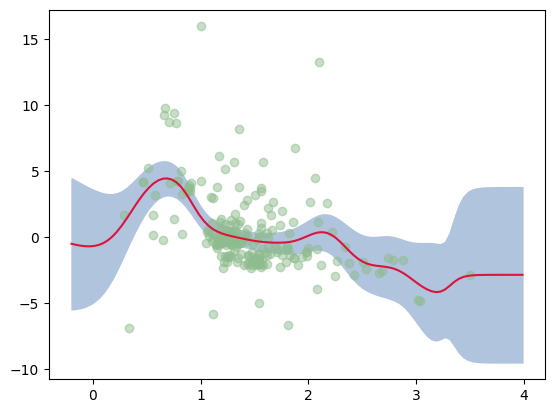

In [12]:
nwke = NWKernelEstimator(response = df['RI'].to_numpy(), covariate = df['Al'].to_numpy())
nwke.set_crossvalidation_bandwidth(h_start=0.1, h_stop=0.2, h_num=100)
print(f"The cross-validation bandwidth is h = {nwke.bandwidth:.3}")

fig, axs = plt.subplots(1)
x, l, u = nwke.confidence_band(axs=axs)
axs.scatter(df['Al'], df['RI'], color='darkseagreen', alpha=0.5)
nwke.plot(axs=axs)

## We now perform test the code above using synthetic data.

The cross-validation bandwidth is h = 0.0227


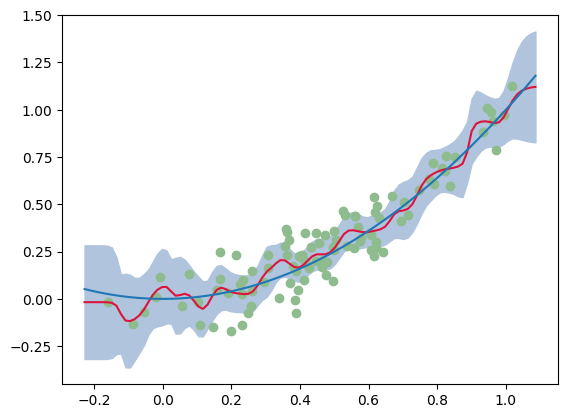

In [173]:
n = 100
X = scipy.stats.norm.rvs(loc=0.5, scale=0.25, size=n)
error = scipy.stats.norm.rvs(scale=0.1, size=n)
Y = X**2 + error

# Generate synthetic data
nwke_synthetic = NWKernelEstimator(response=Y, covariate=X)

# Perform and plot the Nadaraya-Watson kernel estimator and its confidence band
nwke_synthetic.set_crossvalidation_bandwidth(h_start=0.01, h_stop=0.1, h_num=100)
print(f"The cross-validation bandwidth is h = {nwke_synthetic.bandwidth:.3}")
nwke_synthetic.plot()
x, l, u = nwke_synthetic.confidence_band()

# Plot of the true regression function
plt.plot(x, x**2)

# Scatter plot of the data
plt.scatter(X, Y, color='darkseagreen', alpha=1)

plt.show()
plt.close()